         general_category  total_sales
0        Home and Kitchen   2989664.55
1             Electronics   1903427.57
2           Personal Care   1894586.78
3     Fashion Accessories   1489815.15
4     Sports and Outdoors   1156656.48
5           Miscellaneous    719329.95
6              Automotive    685384.32
7         Home and Garden    644145.92
8          Toys and Games    561372.55
9                    Baby    482259.27
10              Furniture    435415.92
11        Office Supplies    277741.71
12             Appliances    268443.02
13                   Pets    253876.65
14    Musical Instruments    210137.37
15                  Tools    165328.00
16  Industry and Commerce    125928.36
17                Fashion     52889.61
18            Marketplace     33834.53
19               Security     28341.56
20                  Books     23379.12
21         Food and Drink     19687.47
22       Holiday Supplies     12030.12
23          Entertainment      8243.12
24         Party Supplies

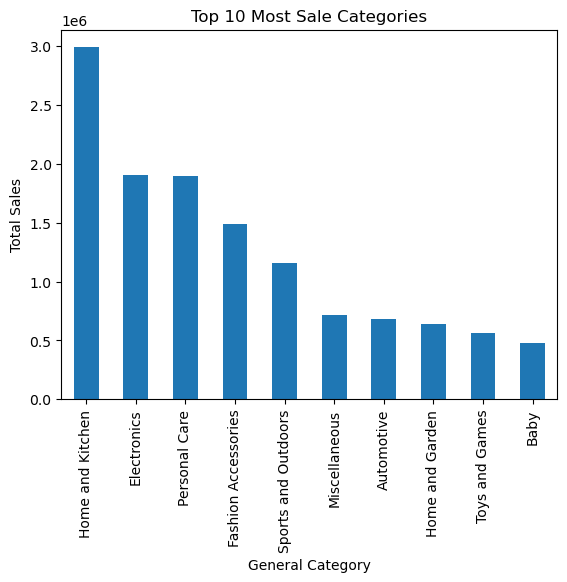

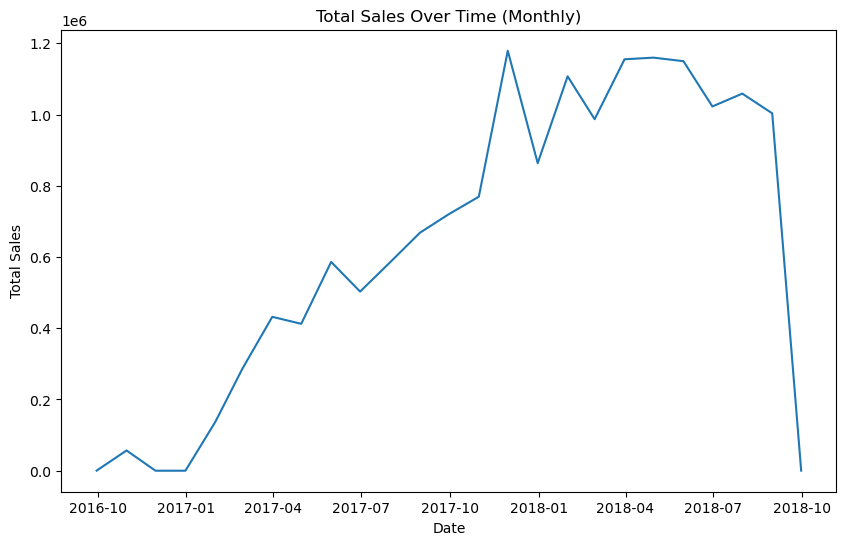

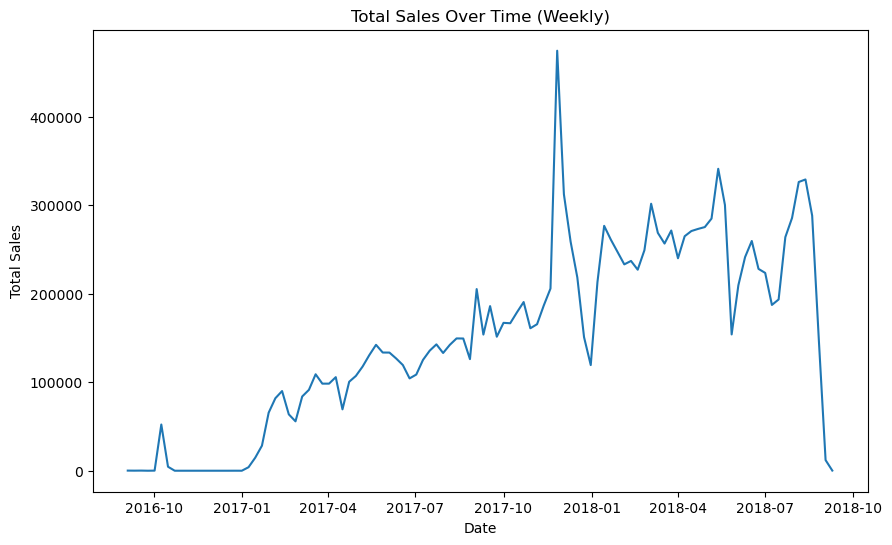

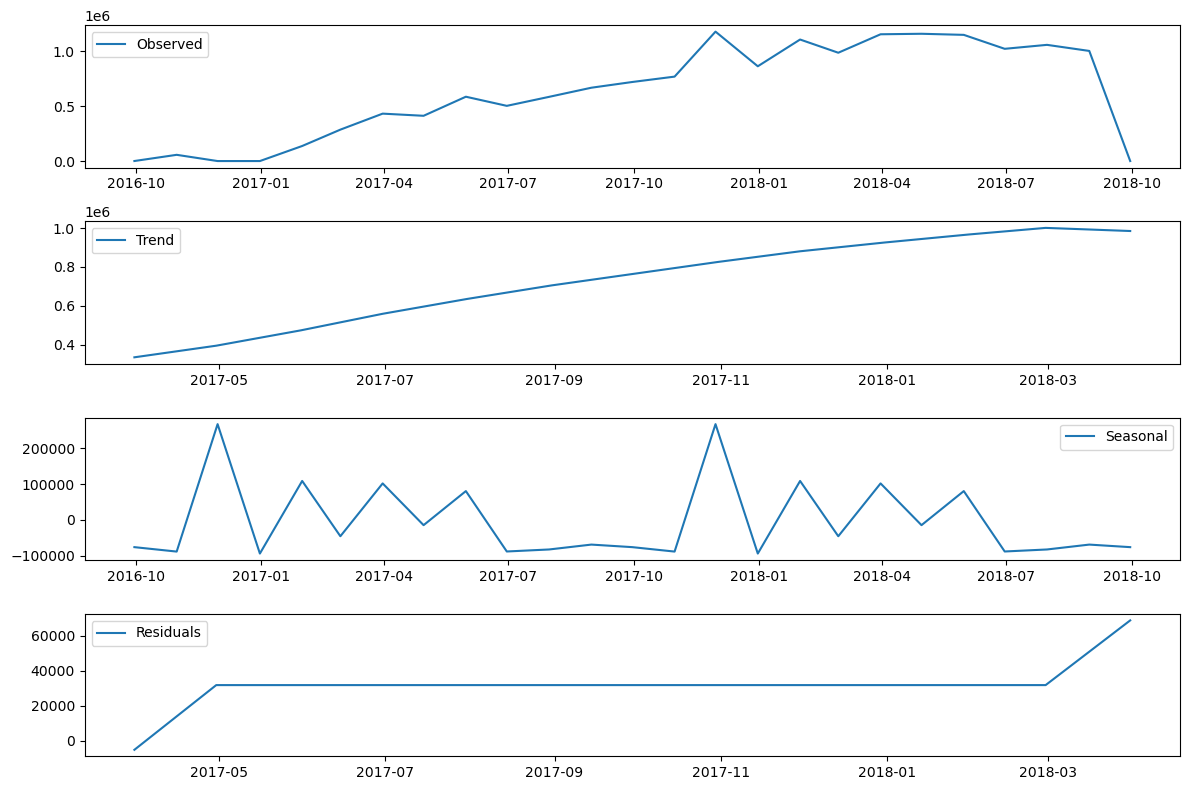

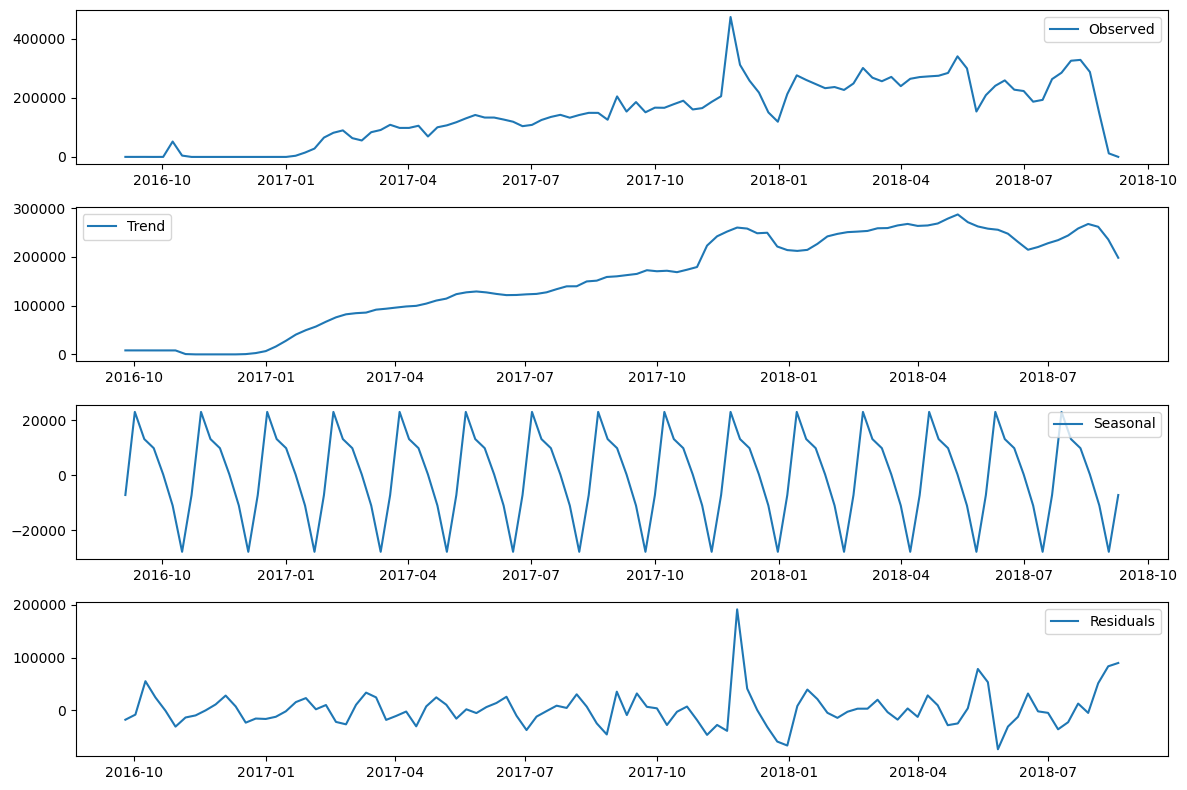

Coefficient (Monthly): 42309.30
Intercept (Monthly): 111967.07
Mean Squared Error (Monthly): 29438528715.89
R2 Score (Monthly): 0.81
Coefficient (Weekly): 2500.96
Intercept (Weekly): 13107.25
Mean Squared Error (Weekly): 6595464982.46
R2 Score (Weekly): 0.62


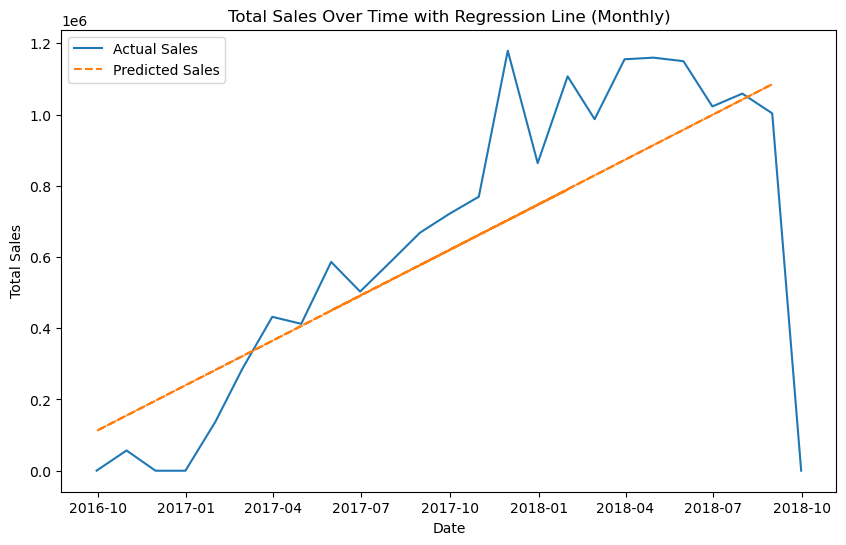

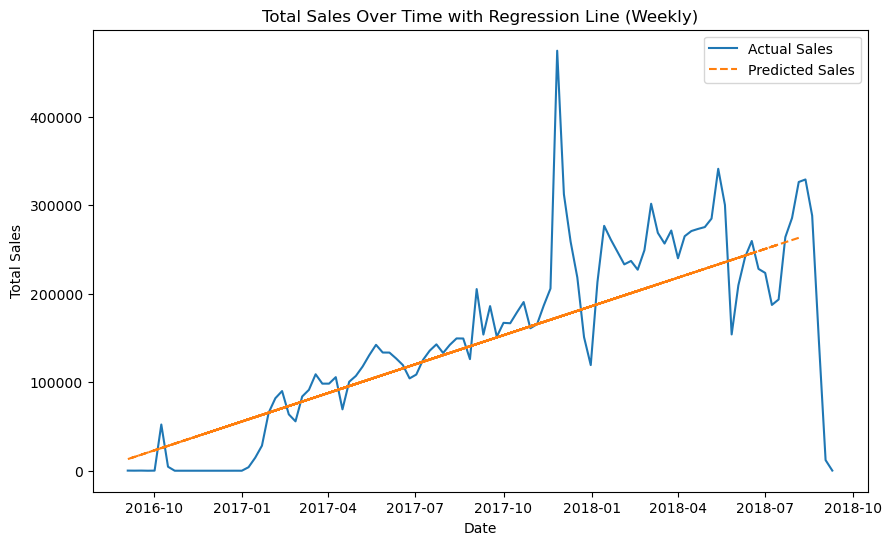

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Load datasets
customers = pd.read_csv('olist_customers_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
translations = pd.read_csv('product_category_name_translation.csv')

# Merge relevant datasets
merged_data = pd.merge(order_items, products, on='product_id')
merged_data = pd.merge(merged_data, orders, on='order_id')
merged_data = pd.merge(merged_data, customers, on='customer_id')
merged_data = pd.merge(merged_data, translations, on='product_category_name', how='left')

# Calculate total sales
merged_data['total_sales'] = merged_data['price'] + merged_data['freight_value']

# Define the provided mapping
category_mapping = {
    'health_beauty': 'Personal Care',
    'computers_accessories': 'Electronics',
    'auto': 'Automotive',
    'bed_bath_table': 'Home and Kitchen',
    'furniture_decor': 'Home and Kitchen',
    'sports_leisure': 'Sports and Outdoors',
    'perfumery': 'Personal Care',
    'housewares': 'Home and Kitchen',
    'telephony': 'Electronics',
    'watches_gifts': 'Fashion Accessories',
    'food_drink': 'Food and Drink',
    'baby': 'Baby',
    'stationery': 'Office Supplies',
    'tablets_printing_image': 'Electronics',
    'toys': 'Toys and Games',
    'garden_tools': 'Home and Garden',
    'fashion_bags_accessories': 'Fashion Accessories',
    'small_appliances': 'Appliances',
    'consoles_games': 'Electronics',
    'audio': 'Electronics',
    'fashion_shoes': 'Fashion',
    'cool_stuff': 'Miscellaneous',
    'air_conditioning': 'Appliances',
    'construction_tools_construction': 'Tools',
    'kitchen_dining_laundry_garden_furniture': 'Home and Garden',
    'fashion_male_clothing': 'Fashion',
    'pet_shop': 'Pets',
    'office_furniture': 'Furniture',
    'market_place': 'Marketplace',
    'electronics': 'Electronics',
    'party_supplies': 'Party Supplies',
    'home_confort': 'Home and Kitchen',
    'agro_industry_and_commerce': 'Industry and Commerce',
    'furniture_mattress_and_upholstery': 'Furniture',
    'books_technical': 'Books',
    'musical_instruments': 'Musical Instruments',
    'furniture_living_room': 'Furniture',
    'industry_commerce_and_business': 'Industry and Commerce',
    'fashion_underwear_beach': 'Fashion',
    'signaling_and_security': 'Security',
    'christmas_supplies': 'Holiday Supplies',
    'cds_dvds_musicals': 'Entertainment',
    'dvds_blu_ray': 'Entertainment',
    'flowers': 'Home and Garden',
    'arts_and_craftsmanship': 'Arts and Crafts',
    'diapers_and_hygiene': 'Baby',
    'security_and_services': 'Security',
}

# Map the product categories to more general categories
merged_data['general_category'] = merged_data['product_category_name_english'].map(category_mapping)

# Convert 'order_purchase_timestamp' to datetime
merged_data['order_purchase_timestamp'] = pd.to_datetime(merged_data['order_purchase_timestamp'])

# Resample total sales over time for monthly trends
time_sales_monthly = merged_data.resample('M', on='order_purchase_timestamp')['total_sales'].sum().reset_index()

# Resample total sales over time for weekly trends
time_sales_weekly = merged_data.resample('W', on='order_purchase_timestamp')['total_sales'].sum().reset_index()

# Linear Regression for Monthly Trends
X_monthly = np.arange(len(time_sales_monthly)).reshape(-1, 1)
y_monthly = time_sales_monthly['total_sales'].values

X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly = train_test_split(
    X_monthly, y_monthly, test_size=0.2, random_state=42)

regressor_monthly = LinearRegression()
regressor_monthly.fit(X_train_monthly, y_train_monthly)
y_pred_monthly = regressor_monthly.predict(X_test_monthly)

# Linear Regression for Weekly Trends
X_weekly = np.arange(len(time_sales_weekly)).reshape(-1, 1)
y_weekly = time_sales_weekly['total_sales'].values

X_train_weekly, X_test_weekly, y_train_weekly, y_test_weekly = train_test_split(
    X_weekly, y_weekly, test_size=0.2, random_state=42)

regressor_weekly = LinearRegression()
regressor_weekly.fit(X_train_weekly, y_train_weekly)
y_pred_weekly = regressor_weekly.predict(X_test_weekly)

# Display sales by general product category
category_sales_table = merged_data.groupby('general_category')['total_sales'].sum().sort_values(ascending=False).reset_index()
print(category_sales_table)

# Display top 10 most sale categories (bar chart)
top_10_categories = merged_data.groupby('general_category')['total_sales'].sum().nlargest(10)
top_10_categories.plot(kind='bar')
plt.title('Top 10 Most Sale Categories')
plt.xlabel('General Category')
plt.ylabel('Total Sales')
plt.show()

# Display total sales over time for monthly trends
plt.figure(figsize=(10, 6))
plt.plot(time_sales_monthly['order_purchase_timestamp'], time_sales_monthly['total_sales'])
plt.title('Total Sales Over Time (Monthly)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

# Display total sales over time for weekly trends
plt.figure(figsize=(10, 6))
plt.plot(time_sales_weekly['order_purchase_timestamp'], time_sales_weekly['total_sales'])
plt.title('Total Sales Over Time (Weekly)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

# Perform seasonal decomposition for monthly trends
result_monthly = seasonal_decompose(time_sales_monthly.set_index('order_purchase_timestamp'), model='additive', period=12)

# Perform seasonal decomposition for weekly trends
result_weekly = seasonal_decompose(time_sales_weekly.set_index('order_purchase_timestamp'), model='additive', period=7)

# Display the decompositions and residuals for monthly trends
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(result_monthly.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(result_monthly.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(result_monthly.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(result_monthly.resid, label='Residuals')
plt.legend()
plt.tight_layout()
plt.show()

# Display the decompositions and residuals for weekly trends
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(result_weekly.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(result_weekly.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(result_weekly.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(result_weekly.resid, label='Residuals')
plt.legend()
plt.tight_layout()
plt.show()

# Regression Analysis for Monthly Trends
print(f'Coefficient (Monthly): {regressor_monthly.coef_[0]:.2f}')
print(f'Intercept (Monthly): {regressor_monthly.intercept_:.2f}')
print(f'Mean Squared Error (Monthly): {mean_squared_error(y_test_monthly, y_pred_monthly):.2f}')
print(f'R2 Score (Monthly): {r2_score(y_test_monthly, y_pred_monthly):.2f}')

# Regression Analysis for Weekly Trends
print(f'Coefficient (Weekly): {regressor_weekly.coef_[0]:.2f}')
print(f'Intercept (Weekly): {regressor_weekly.intercept_:.2f}')
print(f'Mean Squared Error (Weekly): {mean_squared_error(y_test_weekly, y_pred_weekly):.2f}')
print(f'R2 Score (Weekly): {r2_score(y_test_weekly, y_pred_weekly):.2f}')

# Plot the original time series and its regression line for Monthly Trends
plt.figure(figsize=(10, 6))
plt.plot(time_sales_monthly['order_purchase_timestamp'], time_sales_monthly['total_sales'], label='Actual Sales')
plt.plot(time_sales_monthly['order_purchase_timestamp'].iloc[X_test_monthly.flatten()],
         y_pred_monthly, label='Predicted Sales', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Total Sales Over Time with Regression Line (Monthly)')
plt.legend()
plt.show()

# Plot the original time series and its regression line for Weekly Trends
plt.figure(figsize=(10, 6))
plt.plot(time_sales_weekly['order_purchase_timestamp'], time_sales_weekly['total_sales'], label='Actual Sales')
plt.plot(time_sales_weekly['order_purchase_timestamp'].iloc[X_test_weekly.flatten()],
         y_pred_weekly, label='Predicted Sales', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Total Sales Over Time with Regression Line (Weekly)')
plt.legend()
plt.show()
